In [1]:
import pandas as pd
import numpy as np

import os
from sys import argv
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, r2_score
import sklearn

from pathlib import Path

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
classification_datasets = ["breast_cancer", "compas", "diabetes", "income", "iris", "mushroom", "nursery"]
regression_datasets = ["bike_sharing", "facebook", "housing", "real_estate", "solar_flare", "student_scores", "wine_quality"]

datasets = []
datasets.extend(classification_datasets)
datasets.extend(regression_datasets)

cls_models = ["decision_tree", "logit", "nb"]
reg_models = ["decision_tree", "lin_reg"]

data_names = {"breast_cancer":"Breast Cancer", "compas": "COMPAS", "diabetes":"Diabetes", "income": "Adult Income",
              "iris": "Iris", "mushroom": "Mushroom", "nursery": "Nursery", "bike_sharing":"Bike Rentals", 
              "facebook": "Facebook", "housing":"Housing", "real_estate": "Real Estate", "solar_flare": "Solar Flare", 
              "student_scores": "Student Results", "wine_quality": "Wine Quality"}

#PATH = Path(os.getcwd()).parent
PATH = os.getcwd()

# Check Model Accuracy

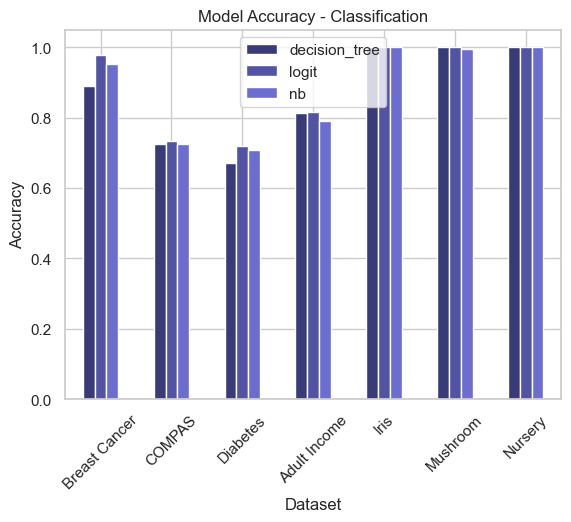

,decision_tree,logit,nb
Breast Cancer,0.890625,0.976562,0.953125
COMPAS,0.724311,0.734336,0.725146
Diabetes,0.670807,0.720497,0.708075
Adult Income,0.812965,0.816153,0.790436
Iris,1.000000,1.000000,1.000000
Mushroom,1.000000,1.000000,0.995319
Nursery,1.000000,1.000000,1.000000


In [3]:
cls_train_acc = np.zeros((len(classification_datasets),len(cls_models)))
cls_test_acc = np.zeros((len(classification_datasets),len(cls_models)))

for i in range(len(classification_datasets)):
    data = classification_datasets[i]
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";").values
    X_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtest.csv"), sep = ";").values
    X_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xvalidation.csv"), sep = ";").values
    test_x = np.vstack([X_test, X_validation])
    
    y_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytrain.csv"), sep = ";").values
    y_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytest.csv"), sep = ";").values
    y_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Yvalidation.csv"), sep = ";").values
    test_y = np.vstack([y_test, y_validation])
    
    for j in range(len(cls_models)):
        classifier = cls_models[j]

        cls = joblib.load(os.path.join(PATH, data, classifier, "cls.joblib"))
        
        train_acc = accuracy_score(y_train, cls.predict(X_train))
        test_acc = accuracy_score(test_y, cls.predict(test_x))

        cls_train_acc[i][j] = train_acc
        cls_test_acc[i][j] = test_acc

df_cls_acc = pd.DataFrame(cls_test_acc, index=[data_names[data] for data in classification_datasets],
                  columns = cls_models)

sns.set_theme(style="whitegrid", palette="tab20b")                  
df_cls_acc.plot.bar()
plt.xticks(rotation = 0)
plt.title("Model Accuracy - Classification")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.xticks(rotation = 45)
#plt.savefig(final_folder+dataset+"_"+cls_method+"_"+bin_type+".eps")
plt.show()

df_cls_acc

In [8]:
from sklearn import tree
import pydotplus

import EncoderFactory
#from DatasetManager_for_colab import DatasetManager
from DatasetManager import DatasetManager
import BucketFactory
from IPython.display import Image, display

from tqdm.notebook import tqdm


dataset = "bpic2012"
bucketing = "prefix"
encoding = "agg"
cls_method = "decision_tree"
save_to = "%s/%s/%s"%(dataset, cls_method, bucketing+"_"+encoding)

dataset_ref_to_datasets = {
    "bpic2012" : ["bpic2012_accepted"],
    "sepsis_cases": ["sepsis_cases_1"],
    "production" : ["production"],
    "bpic2011" : ["bpic2011_f1"],
    "hospital" : ["hospital_billing_2"],
    "traffic" : ["traffic_fines_1"]
}

if bucketing == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"
    
train_accuracy = []
test_accuracy = []

num_buckets = len([name for name in os.listdir(os.path.join(PATH,save_to, 'pipelines'))])

test_prefixes = pd.read_csv(os.path.join(PATH, dataset, "datasets/test_prefixes.csv"))
dataset_manager = DatasetManager(dataset_ref_to_datasets[dataset][0])
dt_test_prefixes = dataset_manager.generate_prefix_data(test_prefixes, 1, 14)

bucketer_args = {'encoding_method':bucket_encoding,
                         'case_id_col':dataset_manager.case_id_col, 
                         'cat_cols':[dataset_manager.activity_col], 
                         'num_cols':[], 
                         'random_state':22}
bucketer = BucketFactory.get_bucketer(bucketing, **bucketer_args)
bucket_assignments_test = bucketer.fit_predict(dt_test_prefixes)

for bucket in tqdm(range(num_buckets)):
    
    bucketID = bucket+1
    print ('Bucket', bucketID)

    pipeline_path = os.path.join(PATH, save_to, "pipelines/pipeline_bucket_%s.joblib" % 
                             (bucketID))
    pipeline = joblib.load(pipeline_path)
    cls = pipeline['cls']

    relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucketID]
    dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
    test_y = dataset_manager.get_label_numeric(dt_test_bucket)
                                               
    X_train = pipeline["scaler"].transform(pd.read_csv(os.path.join(PATH, save_to, "train_data/train_data_bucket_%s.csv" % (bucketID))))
    y_train = pd.read_csv(os.path.join(PATH, save_to, "train_data/y_train_bucket_%s.csv" % (bucketID)))
    
    test_acc = accuracy_score(test_y, pipeline.predict(dt_test_bucket))
    train_acc = accuracy_score(y_train, cls.predict(X_train))
    
    print("Training accuracy", train_acc)
    print("Test accuracy", test_acc)
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    
print("Overall test accuracy", np.mean(test_accuracy))

# # cls = joblib.load(os.path.join(PATH, dataset, "decision_tree", bucketing+"_"+encoding, "pipelines", "pipeline_bucket_1.joblib"))["cls"]
# # X_train = pd.read_csv(os.path.join(PATH, dataset, "datasets", dataset+"_Xtrain.csv"), sep = ";")

#     class_names = ["Negative", "Positive"]

#     dot_data = tree.export_graphviz(cls, out_file=None, feature_names=X_train.columns, class_names=class_names,
#                                     filled=True, rounded=True, special_characters=True)
#     graph = pydotplus.graph_from_dot_data(dot_data)

#     for node in graph.get_node_list():
#         if node.get_attributes().get('label') is None:
#             continue
#         if 'samples = ' in node.get_attributes()['label']:
#             labels = node.get_attributes()['label'].split('<br/>')
#             for i, label in enumerate(labels):
#                 if label.startswith('samples = '):
#                     labels[i] = 'samples = 0'
#             node.set('label', '<br/>'.join(labels))
#             node.set_fillcolor('white')

#     samples = X_train.values[:1]
#     decision_paths = cls.decision_path(samples)

#     for decision_path in decision_paths:
#         for n, node_value in enumerate(decision_path.toarray()[0]):
#             if node_value == 0:
#                 continue
#             node = graph.get_node(str(n))[0]            
#             node.set_fillcolor('green')
#             labels = node.get_attributes()['label'].split('<br/>')
#             for i, label in enumerate(labels):
#                 if label.startswith('samples = '):
#                     labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

#             node.set('label', '<br/>'.join(labels))
                                               
#     display(Image(graph.create_png()))

prefix


  0%|          | 0/14 [00:00<?, ?it/s]

Bucket 1
Training accuracy 0.5349519743863393
Test accuracy 0.5496264674493063
Bucket 2
Training accuracy 0.5248132337246532
Test accuracy 0.5400213447171825
Bucket 3
Training accuracy 0.5272145144076841
Test accuracy 0.5133404482390609
Bucket 4
Training accuracy 0.5370864461045891
Test accuracy 0.5250800426894343
Bucket 5
Training accuracy 0.6101468624833111
Test accuracy 0.5410885805763074
Bucket 6
Training accuracy 0.5913461538461539
Test accuracy 0.5464247598719317
Bucket 7
Training accuracy 0.5865204600160471
Test accuracy 0.551760939167556
Bucket 8
Training accuracy 0.5479892761394102
Test accuracy 0.5026680896478122
Bucket 9
Training accuracy 0.524422973698336
Test accuracy 0.5144076840981857
Bucket 10
Training accuracy 0.5394736842105263
Test accuracy 0.5154749199573105
Bucket 11
Training accuracy 0.6166666666666667
Test accuracy 0.5080042689434365
Bucket 12
Training accuracy 0.6447014523937601
Test accuracy 0.5699039487726788
Bucket 13
Training accuracy 0.5771554091158704
Test

In [5]:
X_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
reg_train_acc = np.zeros((len(regression_datasets),len(reg_models)))
reg_test_acc = np.zeros((len(regression_datasets),len(reg_models)))

for i in range(len(regression_datasets)):
    data = regression_datasets[i]
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";").values
    X_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtest.csv"), sep = ";").values
    X_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xvalidation.csv"), sep = ";").values
    test_x = np.vstack([X_test, X_validation])
    
    y_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytrain.csv"), sep = ";").values
    y_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytest.csv"), sep = ";").values
    y_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Yvalidation.csv"), sep = ";").values
    test_y = np.vstack([y_test, y_validation])
    
    for j in range(len(reg_models)):
        model = reg_models[j]

        reg = joblib.load(os.path.join(PATH, data, model, "cls.joblib"))
        
        train_acc = r2_score(y_train, reg.predict(X_train))
        test_acc = r2_score(test_y, reg.predict(test_x))

        reg_train_acc[i][j] = train_acc
        reg_test_acc[i][j] = test_acc

df_reg_acc = pd.DataFrame(reg_test_acc, index=[data_names[data] for data in regression_datasets],
                  columns = reg_models)

sns.set_theme(style="whitegrid", palette="tab20b")                  
df_reg_acc.plot.bar()
plt.xticks(rotation = 0)
plt.title("Model Accuracy - Regression")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.ylim(-1.1, 1.1)
plt.xticks(rotation = 45)
#plt.savefig(final_folder+dataset+"_"+cls_method+"_"+bin_type+".eps")
plt.show()

df_reg_acc

# Generate Model Architecture Stats

In [ ]:
def get_tree_characteristics(tree, feat_list, cur_depth = 0, lvl = 0, depths = [], split_nodes = [], leaf_nodes = []):

    left_child = tree.children_left[lvl]
    right_child = tree.children_right[lvl]
    
    if left_child == sklearn.tree._tree.TREE_LEAF:
        depths.append(cur_depth)
        leaf_nodes.append(lvl)
        
    else:
        split_nodes.append(lvl)
        depths, split_nodes, leaf_nodes = get_tree_characteristics(tree, feat_list, cur_depth+1, left_child, depths, split_nodes, leaf_nodes)
        depths, split_noes, leaf_nodes = get_tree_characteristics(tree, feat_list, cur_depth+1, right_child, depths, split_nodes, leaf_nodes)
        
    return depths, split_nodes, leaf_nodes

In [ ]:
print("Decision Tree Characteristics")
char = pd.DataFrame(columns = ["Dataset", "Max Depth", "Splits", "Leaves"])

for data in datasets:
    split_nodes = []
    leaf_nodes = []
    
    cls = joblib.load(os.path.join(PATH, data, "decision_tree", "cls.joblib"))
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";")
    depths, split_nodes, leaf_nodes = get_tree_characteristics(cls.tree_, X_train.columns, split_nodes = split_nodes, leaf_nodes = leaf_nodes)
    
    max_depth = cls.get_depth()
    splits = len(split_nodes)
    leaves = len(leaf_nodes)
    
    char = char.append({"Dataset":data_names[data], "Max Depth": max_depth, "Splits": splits, "Leaves": leaves}, ignore_index=True)
char

# Tree Visualisation (DT)

In [ ]:
from sklearn import tree
import pydotplus

dataset = "diabetes"

cls = joblib.load(os.path.join(PATH, dataset, "decision_tree", "cls.joblib"))
X_train = pd.read_csv(os.path.join(PATH, dataset, "datasets", dataset+"_Xtrain.csv"), sep = ";")

class_names = ["Negative", "Positive"]

dot_data = tree.export_graphviz(cls, out_file=None, feature_names=X_train.columns, class_names=class_names,
                                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

samples = X_train.values[:1]
decision_paths = cls.decision_path(samples)

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

In [ ]:
from IPython.display import Image
Image(graph.create_png())

# DT Visualisation (Event Log)

  0%|          | 0/1 [00:00<?, ?it/s]

Bucket 1


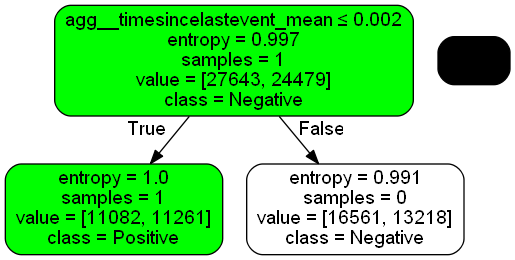

In [3]:
from sklearn import tree
import pydotplus

import EncoderFactory
#from DatasetManager_for_colab import DatasetManager
from DatasetManager import DatasetManager
import BucketFactory
from IPython.display import Image, display

from tqdm.notebook import tqdm


dataset = "bpic2012"
bucketing = "single"
encoding = "agg"

save_to = "%s/decision_tree/%s"%(dataset, bucketing+"_"+encoding)

num_buckets = len([name for name in os.listdir(os.path.join(PATH,save_to, 'pipelines'))])

for bucket in tqdm(range(num_buckets)):
    
    bucketID = bucket+1
    print ('Bucket', bucketID)

    pipeline_path = os.path.join(PATH, save_to, "pipelines/pipeline_bucket_%s.joblib" % 
                             (bucketID))
    pipeline = joblib.load(pipeline_path)
    cls = pipeline['cls']
                                               
    X_train = pd.read_csv(os.path.join(PATH, save_to, "train_data/train_data_bucket_%s.csv" % (bucketID)))



# cls = joblib.load(os.path.join(PATH, dataset, "decision_tree", bucketing+"_"+encoding, "pipelines", "pipeline_bucket_1.joblib"))["cls"]
# X_train = pd.read_csv(os.path.join(PATH, dataset, "datasets", dataset+"_Xtrain.csv"), sep = ";")

    class_names = ["Negative", "Positive"]

    dot_data = tree.export_graphviz(cls, out_file=None, feature_names=X_train.columns, class_names=class_names,
                                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    for node in graph.get_node_list():
        if node.get_attributes().get('label') is None:
            continue
        if 'samples = ' in node.get_attributes()['label']:
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = 0'
            node.set('label', '<br/>'.join(labels))
            node.set_fillcolor('white')

    samples = X_train.values[:1]
    decision_paths = cls.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))
                                               
    display(Image(graph.create_png()))

In [ ]:
os.path.join(PATH, save_to, "train_data/train_data_bucket_%s.csv" % (bucketID))

In [ ]:
save_to

# Coefficient Visualisation (Logit and Lin Reg)

In [ ]:
dataset = "diabetes"
model="logit"

cls = joblib.load(os.path.join(PATH, dataset, model, "cls.joblib"))
X_train = pd.read_csv(os.path.join(PATH, dataset, "datasets", dataset+"_Xtrain.csv"), sep = ";")

coefs = sorted(cls.coef_.reshape(X_train.shape[1]), reverse=True)
plt.plot(coefs)
plt.xlabel("Feature ID")
plt.ylabel("Model Coefficient")
plt.show()

# Coefficient Visualisation (EL)

In [ ]:
import EncoderFactory
#from DatasetManager_for_colab import DatasetManager
from DatasetManager import DatasetManager
import BucketFactory
from IPython.display import Image, display

from tqdm.notebook import tqdm

dataset = "bpic2011"
bucketing = "prefix"
encoding = "agg"

save_to = "%s/logit/%s"%(dataset, bucketing+"_"+encoding)

num_buckets = len([name for name in os.listdir(os.path.join(PATH,save_to, 'pipelines'))])

for bucket in tqdm(range(num_buckets)):
    
    bucketID = bucket+1
    print ('Bucket', bucketID)

    pipeline_path = os.path.join(PATH, save_to, "pipelines/pipeline_bucket_%s.joblib" % 
                             (bucketID))
    pipeline = joblib.load(pipeline_path)
    cls = pipeline['cls']
                                               
    X_train = pd.read_csv(os.path.join(PATH, save_to, "train_data/train_data_bucket_%s.csv" % (bucketID)))


    coefs = sorted(np.abs(cls.coef_).reshape(X_train.shape[1]), reverse=True)
    
    min_coef = min(coefs)
    max_coef = max(coefs)
    
    k = (max_coef-min_coef)*0.05
    q1_min = max_coef - k

    plt.scatter(np.arange(X_train.shape[1]), coefs)
    plt.plot(np.arange(X_train.shape[1]), [q1_min]*X_train.shape[1])
    plt.xlabel("Feature ID")
    plt.ylabel("Model Coefficient")
    plt.show()

# Likelihood Visualisation (Naive Bayes)

In [ ]:
from scipy.stats import norm
dataset = "diabetes"

cls = joblib.load(os.path.join(PATH, dataset, "nb", "cls.joblib"))
X_train = pd.read_csv(os.path.join(PATH, dataset, "datasets", dataset+"_Xtrain.csv"), sep = ";")

means = cls.theta_.transpose()
std_devs = np.sqrt(cls.var_).transpose()
vals = X_train.values.transpose()
feat_list = X_train.columns

for i in range(len(feat_list)):
    print(feat_list[i])
    neg_lkhoods = norm.pdf(means[i][0], std_devs[i][0], vals[i])
    pos_lkhoods = norm.pdf(means[i][1], std_devs[i][1], vals[i])
    control_0 = norm.pdf(means[i][0], std_devs[i][0], np.linspace(0,1,100))
    control_1 = norm.pdf(means[i][1], std_devs[i][1], np.linspace(0,1,100))
    
    plt.scatter(vals[i], neg_lkhoods, color="red", label="Training set if negative")
    plt.scatter(vals[i], pos_lkhoods, color="green", label="Training set if positive")
    plt.xlim(-0.001,1.001)
    plt.ylim(ymin=-0.001)
    plt.title("Likelihood distribution for "+feat_list[i])
    plt.xlabel("Feature Value")
    plt.ylabel("Likelihood")
    plt.legend()
    plt.show()

    plt.scatter(np.linspace(0,1,100), control_0, color="pink", label="Neg class likelihood distribution")
    plt.scatter(np.linspace(0,1,100), control_1, color="lightgreen", label="Pos class likelihood distribution")
    plt.xlim(-0.001,1.001)
    plt.ylim(ymin=-0.001)
    plt.title("Likelihood distribution for "+feat_list[i])
    plt.xlabel("Feature Value")
    plt.ylabel("Likelihood")
    plt.legend()
    plt.show()